# Modeling Baseline Pipeline for Phishing URL Detection

In this notebook, we build a full modeling pipeline for detecting phishing URLs.  
We start with a dataset that contains two columns: a **URL** and a **label** indicating whether the URL is **benign** or **phishing**.

While we use a well-known research dataset for this example (PhishStorm), **any dataset with labeled URLs** can be used — because **all features in this pipeline will be created from scratch** using custom Python functions.

PhishTank dataset is our addditioonal dataset. It has 50K additional phishing links. 

📘 **Datasets citation**:  

> [1] S. Marchal, J. Francois, R. State, and T. Engel.  
> *PhishStorm: Detecting Phishing with Streaming Analytics*.  
> IEEE Transactions on Network and Service Management (TNSM), 11(4):458–471, 2014.

> PhishTank: https://phishtank.org/developer_info.php (dowloaded on Oct 4th 2025, the dataset is updated every day but we will use Oct 4th version)

> Alexa 1 million TOP popular domains: https://www.kaggle.com/datasets/nayjest/alexa-domains-1m/data?select=alexa_domains_1M.txt

## Set up

In [1]:
# Confirm we are in the correct venv
import sys
print(sys.executable)

/Users/polinacsv/Documents/github_clones/phishing_URL_detection/.venv/bin/python


In [2]:
# Load libraries
from phishing_URL_detection.load_data import *
from phishing_URL_detection.features import *
from urllib.parse import urlparse, parse_qs  # 

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import joblib, json


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix
)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score






# Load Data

In [3]:
# Load the Web page Phishing Detection dataset

df_phishing = load_phishing_data(
    data_dir='../data',
    filename='dataset_phishing.csv', 
    url_col='url',        
    label_col='status'     
)

# Quick preview
df_phishing.head()

,url,label
0,http://www.crestonwood.com/router.php,0
1,http://shadetreetechnology.com/V4/validation/a...,1
2,https://support-appleld.com.secureupdate.duila...,1
3,http://rgipt.ac.in,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0


In [5]:
df_phishing.groupby('label').size()

label
0    5715
1    5715
dtype: int64

In [6]:
df_phishing.shape

(11430, 2)

Next, let's load a list of the most visited domains globally from the Alexa Top 1M dataset. This list serves as a proxy for trusted or popular websites.

We'll use it later to engineer features that indicate whether a domain in a URL appears in this trusted set, which may help differentiate between phishing and legitimate URLs.

In [7]:
# Load the Alexa domain list
alexa_df = load_alexa_domains(
    data_dir='../data',
    filename='alexa_domains_1M.txt'
)

alexa_df.head()

,alexa_domain,ranking
0,google.com,1
1,facebook.com,2
2,youtube.com,3
3,baidu.com,4
4,yahoo.com,5


In [8]:
alexa_df.shape

(1000000, 2)

In [9]:
# Take random samples 
sample_alexa = alexa_df.sample(n=200, random_state=42)   # 200 rows from PhishStorm

# Save samples for upload 
sample_alexa.to_csv("../data/sample_alexa.csv", index=False)

# EDA

In [10]:
# Basic inspection
shape = df_phishing.shape
head = df_phishing.head(10)
label_counts = df_phishing['label'].value_counts(normalize=False)
label_distribution = df_phishing['label'].value_counts(normalize=True)

shape, head, label_counts, label_distribution

((11430, 2),
                                                  url  label
 0              http://www.crestonwood.com/router.php      0
 1  http://shadetreetechnology.com/V4/validation/a...      1
 2  https://support-appleld.com.secureupdate.duila...      1
 3                                 http://rgipt.ac.in      0
 4  http://www.iracing.com/tracks/gateway-motorspo...      0
 5                   http://appleid.apple.com-app.es/      1
 6                                http://www.mutuo.it      0
 7  http://www.shadetreetechnology.com/V4/validati...      1
 8         http://vamoaestudiarmedicina.blogspot.com/      0
 9  https://parade.com/425836/joshwigler/the-amazi...      0,
 label
 0    5715
 1    5715
 Name: count, dtype: int64,
 label
 0    0.5
 1    0.5
 Name: proportion, dtype: float64)

## Feature engineering

### Alexa-based features

We use the Alexa Top 1M domain list to generate two features that indicate how globally popular or common a domain is:

- **`is_in_alexa`**: A binary flag indicating whether the main-level domain (`mld_ps`) of the URL is in the Alexa Top 1M list (1 = yes, 0 = no).
- **`ranking`**: The popularity rank of the domain (1 = most popular). If the domain is not in Alexa, we impute it with 1,000,001 - just outside the Top 1M.

These features are based on the assumption that phishing URLs are less likely to use popular or trusted domains.

In [11]:
# Add mld_ps column
df_phishing_feat = add_alexa_features(df_phishing, alexa_df)

# Preview
df_phishing_feat[['url', 'mld_ps', 'is_in_alexa', 'ranking']].head()

,url,mld_ps,is_in_alexa,ranking
0,http://www.crestonwood.com/router.php,crestonwood.com,0,1000001
1,http://shadetreetechnology.com/V4/validation/a...,shadetreetechnology.com,0,1000001
2,https://support-appleld.com.secureupdate.duila...,duilawyeryork.com,0,1000001
3,http://rgipt.ac.in,rgipt.ac.in,1,914181
4,http://www.iracing.com/tracks/gateway-motorspo...,iracing.com,1,29578


In [12]:
df_phishing_feat.head()

,url,label,mld_ps,is_in_alexa,ranking
0,http://www.crestonwood.com/router.php,0,crestonwood.com,0,1000001
1,http://shadetreetechnology.com/V4/validation/a...,1,shadetreetechnology.com,0,1000001
2,https://support-appleld.com.secureupdate.duila...,1,duilawyeryork.com,0,1000001
3,http://rgipt.ac.in,0,rgipt.ac.in,1,914181
4,http://www.iracing.com/tracks/gateway-motorspo...,0,iracing.com,1,29578


In [13]:
df_phishing_feat[['is_in_alexa', 'ranking']].describe()

,is_in_alexa,ranking
count,11430.000000,1.143000e+04
mean,0.492213,5.663305e+05
std,0.499961,4.654664e+05
min,0.000000,1.000000e+00
25%,0.000000,9.994000e+03
50%,0.000000,1.000001e+06
75%,1.000000,1.000001e+06
max,1.000000,1.000001e+06


In [14]:
df_phishing_feat.groupby("label")["ranking"].mean()

label
0    353810.087839
1    778850.990376
Name: ranking, dtype: float64

In [15]:
df_phishing_feat.groupby("label")["is_in_alexa"].mean()

label
0    0.742082
1    0.242345
Name: is_in_alexa, dtype: float64

In [16]:
pd.crosstab(df_phishing_feat['label'], df_phishing_feat['is_in_alexa'])

is_in_alexa,0,1
label,,
0,1474,4241
1,4330,1385


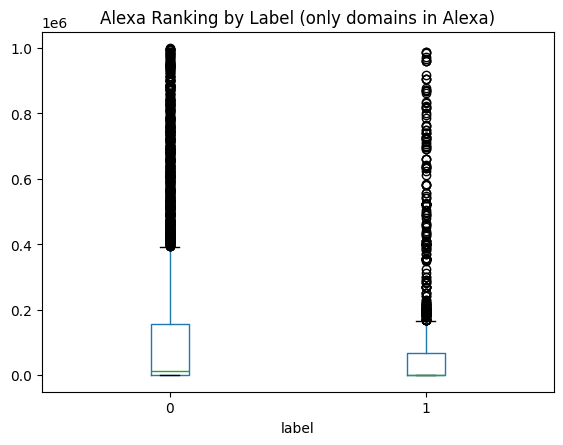

In [17]:
df_phishing_feat[df_phishing_feat['is_in_alexa']==1].boxplot(
    column='ranking', by='label', grid=False
)
plt.suptitle("")
plt.title("Alexa Ranking by Label (only domains in Alexa)")
plt.show()

In [18]:
df_phishing_feat[['label', 'is_in_alexa', 'ranking']].corr()

,label,is_in_alexa,ranking
label,1.000000,-0.499798,0.456595
is_in_alexa,-0.499798,1.000000,-0.946356
ranking,0.456595,-0.946356,1.000000


In [19]:
alexa_df.head()

,alexa_domain,ranking
0,google.com,1
1,facebook.com,2
2,youtube.com,3
3,baidu.com,4
4,yahoo.com,5


In [22]:
# PhishTank: enrich with Alexa features 
df_tank_feat  = add_alexa_features(df_tank,  alexa_df)

#  Alexa benign set
#  Just align columns for comparison:
df_alexa_feat = alexa_df.rename(columns={"alexa_domain": "mld_ps"}) \
                        .assign(
                            url=lambda d: d["mld_ps"],
                            is_in_alexa=1
                        )[["url", "mld_ps", "ranking", "is_in_alexa"]]

In [20]:
df_phishing_feat = add_suspicious_subdomain_or_path(df_phishing_feat)

df_phishing_feat = add_is_url_shortener(df_phishing_feat)

In [21]:
df_phishing_feat.head()

,url,label,mld_ps,is_in_alexa,ranking,suspicious_subdomain_or_path,is_url_shortener
0,http://www.crestonwood.com/router.php,0,crestonwood.com,0,1000001,0,0
1,http://shadetreetechnology.com/V4/validation/a...,1,shadetreetechnology.com,0,1000001,0,0
2,https://support-appleld.com.secureupdate.duila...,1,duilawyeryork.com,0,1000001,1,0
3,http://rgipt.ac.in,0,rgipt.ac.in,1,914181,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,iracing.com,1,29578,0,0


In [22]:
# Basic summaries
cols = ["suspicious_subdomain_or_path", "is_url_shortener"]
display(df_phishing_feat[cols].describe())

# Class-wise averages (how often these features fire in each class)
display(df_phishing_feat.groupby("label")[cols].mean().rename_axis("label"))

# Crosstabs vs label (counts + row-normalized %)
for c in cols:
    print(f"\n=== {c} vs label ===")
    ct = pd.crosstab(df_phishing_feat[c], df_phishing_feat["label"], margins=True)
    display(ct)
    ctp = pd.crosstab(df_phishing_feat[c], df_phishing_feat["label"], normalize="index").round(3)
    display(ctp)

,suspicious_subdomain_or_path,is_url_shortener
count,11430.000000,11430.000000
mean,0.260192,0.004112
std,0.438759,0.063996
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


,suspicious_subdomain_or_path,is_url_shortener
label,,
0,0.097463,0.000000
1,0.422922,0.008224



=== suspicious_subdomain_or_path vs label ===


label,0,1,All
suspicious_subdomain_or_path,,,
0,5158,3298,8456
1,557,2417,2974
All,5715,5715,11430


label,0,1
suspicious_subdomain_or_path,,
0,0.610,0.390
1,0.187,0.813



=== is_url_shortener vs label ===


label,0,1,All
is_url_shortener,,,
0,5715,5668,11383
1,0,47,47
All,5715,5715,11430


label,0,1
is_url_shortener,,
0,0.502,0.498
1,0.000,1.000


In [23]:
for c in cols:
    print(f"\n[PhishTank] {c} mean:", float(df_phishing_feat[c].mean()))


[PhishTank] suspicious_subdomain_or_path mean: 0.26019247594050743

[PhishTank] is_url_shortener mean: 0.0041119860017497815


In [26]:
df_phishing_feat.head()

,url,label,mld_ps,is_in_alexa,log_ranking,suspicious_subdomain_or_path,is_url_shortener
0,http://www.crestonwood.com/router.php,0,crestonwood.com,0,13.815513,0,0
1,http://shadetreetechnology.com/V4/validation/a...,1,shadetreetechnology.com,0,13.815513,0,0
2,https://support-appleld.com.secureupdate.duila...,1,duilawyeryork.com,0,13.815513,1,0
3,http://rgipt.ac.in,0,rgipt.ac.in,1,13.725785,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,iracing.com,1,10.294820,0,0


In [25]:
df_phishing_feat = add_alexa_features(df_phishing, alexa_df)
df_phishing_feat = add_alexa_transforms(df_phishing_feat)
df_phishing_feat = add_suspicious_subdomain_or_path(df_phishing_feat)
df_phishing_feat = add_is_url_shortener(df_phishing_feat)

df_phishing_feat[["url", "is_in_alexa", "log_ranking"]].head()

,url,is_in_alexa,log_ranking
0,http://www.crestonwood.com/router.php,0,13.815513
1,http://shadetreetechnology.com/V4/validation/a...,0,13.815513
2,https://support-appleld.com.secureupdate.duila...,0,13.815513
3,http://rgipt.ac.in,1,13.725785
4,http://www.iracing.com/tracks/gateway-motorspo...,1,10.294820


### Jaccard-based features: measuring token similarity in URLs

We introduce two Jaccard similarity features to capture structural overlap between parts of a URL and its main domain:

1. **`jaccard_mld_path`**: Measures the overlap of tokens between the main domain (`mld_ps`) and the URL path.
   - Example: Comparing `paypal.com` with `/paypal/login` → high similarity.
   - Phishing URLs often reuse brand names in the path to mislead users.

2. **`jaccard_subdomain_path`**: Measures overlap between the *subdomain* and the path.
   - Example: Comparing `accounts.paypal.com` with `/paypal/signin` might show higher overlap.
   - Phishing sites may encode target keywords in both subdomains and paths.

These features are helpful because benign domains often have meaningful, structured URL paths, while phishing domains tend to reuse brand names inconsistently across subdomains and paths.

We compute these similarities using the **Jaccard index**, which compares the intersection and union of token sets. A higher value indicates greater structural overlap.

Let’s now generate and explore these features:

In [27]:
df_phishing_feat = extract_jaccard_features(df_phishing_feat)
df_phishing_feat[["jaccard_mld_path", "jaccard_subdomain_path"]].describe()

,jaccard_mld_path,jaccard_subdomain_path
count,11430.000000,11430.000000
mean,0.005244,0.002005
std,0.034922,0.025774
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,0.500000,1.000000


In [28]:
cols = ["jaccard_mld_path", "jaccard_subdomain_path"]

# 1) overall summary
display(df_phishing_feat[cols].describe())

# 2) class-wise averages (higher in phishing = useful)
display(df_phishing_feat.groupby("label")[cols].mean().rename_axis("label"))

# 3) simple bins to see separation
for c in cols:
    print(f"\n=== {c} binned vs label ===")
    bins = pd.qcut(df_phishing_feat[c], q=[0, .5, .9, .99, 1.0], duplicates="drop")
    display(pd.crosstab(bins, df_phishing_feat["label"], normalize="index").round(3))


,jaccard_mld_path,jaccard_subdomain_path
count,11430.000000,11430.000000
mean,0.005244,0.002005
std,0.034922,0.025774
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,0.500000,1.000000


,jaccard_mld_path,jaccard_subdomain_path
label,,
0,0.004158,0.001910
1,0.006330,0.002101



=== jaccard_mld_path binned vs label ===


label,0,1
jaccard_mld_path,,
"(-0.001, 0.2]",0.501,0.499
"(0.2, 0.5]",0.400,0.600



=== jaccard_subdomain_path binned vs label ===


label,0,1
jaccard_subdomain_path,,
"(-0.001, 1.0]",0.5,0.5


In [29]:
df_phishing_feat[["label","jaccard_mld_path","jaccard_subdomain_path"]].corr()


,label,jaccard_mld_path,jaccard_subdomain_path
label,1.000000,0.031103,0.003710
jaccard_mld_path,0.031103,1.000000,0.050059
jaccard_subdomain_path,0.003710,0.050059,1.000000


In [30]:
df_phishing_feat[[
    "jaccard_hostname_path",
    "jaccard_mld_query",
    "jaccard_subdomain_query",
    "jaccard_path_query",
    "path_self_similarity"
]].describe()

,jaccard_hostname_path,jaccard_mld_query,jaccard_subdomain_query,jaccard_path_query,path_self_similarity
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000
mean,0.005603,0.002026,0.000415,0.001057,0.269230
std,0.033598,0.021859,0.010173,0.013789,0.291335
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.200000
75%,0.000000,0.000000,0.000000,0.000000,0.333333
max,0.833333,0.400000,0.333333,0.615385,1.000000


In [31]:
df_phishing_feat.groupby("label")[[
    "jaccard_hostname_path",
    "jaccard_mld_query",
    "jaccard_subdomain_query",
    "jaccard_path_query",
    "path_self_similarity"
]].mean()

,jaccard_hostname_path,jaccard_mld_query,jaccard_subdomain_query,jaccard_path_query,path_self_similarity
label,,,,,
0,0.004506,0.001379,0.000058,0.000154,0.207318
1,0.006701,0.002672,0.000771,0.001959,0.331143


In [32]:
(pd.crosstab(
    df_phishing_feat["label"],
    df_phishing_feat["jaccard_hostname_path"] > 0
) / len(df_phishing_feat)).round(3)

jaccard_hostname_path,False,True
label,,
0,0.487,0.013
1,0.477,0.023


In [33]:
df_phishing_feat[[
    "jaccard_hostname_path",
    "jaccard_mld_query",
    "jaccard_subdomain_query",
    "jaccard_path_query",
    "path_self_similarity",
    "jaccard_mld_path",
    "jaccard_subdomain_path"
]].corr()

,jaccard_hostname_path,jaccard_mld_query,jaccard_subdomain_query,jaccard_path_query,path_self_similarity,jaccard_mld_path,jaccard_subdomain_path
jaccard_hostname_path,1.000000,-0.008583,0.005278,0.006169,0.021120,0.844593,0.523994
jaccard_mld_query,-0.008583,1.000000,0.135260,0.044607,0.042335,-0.007343,-0.006444
jaccard_subdomain_query,0.005278,0.135260,1.000000,0.038555,0.005751,-0.006120,0.014390
jaccard_path_query,0.006169,0.044607,0.038555,1.000000,0.017451,0.007674,-0.005963
path_self_similarity,0.021120,0.042335,0.005751,0.017451,1.000000,0.029970,0.016872
jaccard_mld_path,0.844593,-0.007343,-0.006120,0.007674,0.029970,1.000000,0.050059
jaccard_subdomain_path,0.523994,-0.006444,0.014390,-0.005963,0.016872,0.050059,1.000000


In [37]:
# drop unused Jaccard features
drop_cols = [
    "jaccard_mld_query",
    "jaccard_subdomain_query",
]

df_phishing_feat = df_phishing_feat.drop(columns=[c for c in drop_cols if c in df_phishing_feat.columns])

# confirm remaining Jaccard features
df_phishing_feat.filter(like="jaccard").head()

,jaccard_mld_path,jaccard_subdomain_path,jaccard_hostname_path,jaccard_path_query
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [36]:
df_phishing_feat.head()

,url,label,mld_ps,is_in_alexa,log_ranking,suspicious_subdomain_or_path,is_url_shortener,full_url,jaccard_mld_path,jaccard_subdomain_path,jaccard_hostname_path,jaccard_path_query,path_self_similarity
0,http://www.crestonwood.com/router.php,0,crestonwood.com,0,13.815513,0,0,http://www.crestonwood.com/router.php,0.0,0.0,0.0,0.0,0.500000
1,http://shadetreetechnology.com/V4/validation/a...,1,shadetreetechnology.com,0,13.815513,0,0,http://shadetreetechnology.com/V4/validation/a...,0.0,0.0,0.0,0.0,0.333333
2,https://support-appleld.com.secureupdate.duila...,1,duilawyeryork.com,0,13.815513,1,0,https://support-appleld.com.secureupdate.duila...,0.0,0.0,0.0,0.0,0.500000
3,http://rgipt.ac.in,0,rgipt.ac.in,1,13.725785,0,0,http://rgipt.ac.in,0.0,0.0,0.0,0.0,0.000000
4,http://www.iracing.com/tracks/gateway-motorspo...,0,iracing.com,1,10.294820,0,0,http://www.iracing.com/tracks/gateway-motorspo...,0.0,0.0,0.0,0.0,0.250000


We engineered several Jaccard similarity features to measure token overlap between different URL components.  
After analysis of distributions, crosstabs, and correlations, we refined the set to balance **signal strength** and **redundancy**:

#### ✅ Kept Features
- **`jaccard_mld_path`** – captures overlap between the *main domain* (e.g., `paypal`) and the *path*.  
  - Useful because phishing URLs often reuse brand names in paths to appear legitimate.  

- **`jaccard_subdomain_path`** – overlap between *subdomain* and *path*.  
  - Phishers frequently echo tokens (e.g., `login.paypal.com/PayPalVerify`) in subdomains and paths.  

- **`jaccard_hostname_path`** – overlap between the *entire hostname* and the *path*.  
  - A compact but strong signal; complements the more granular MLD vs. subdomain comparisons.  

- **`jaccard_path_query`** – overlap between *path* and *query string* tokens.  
  - Captures suspicious repetition when phishy parameters (like `login`, `verify`) echo tokens from the path.  

- **`path_self_similarity`** – ratio of repeated tokens within the *path*.  
  - Detects artificially repetitive paths, a common obfuscation trick in phishing URLs.  

Together, these five features cover a wide range of **token echo patterns** between domains, paths, and queries.  

#### ❌ Dropped Features
- **`jaccard_mld_query`** – overlap between *main domain* and *query tokens*.  
  - Rarely triggered and added little discriminative power.  

- **`jaccard_subdomain_query`** – overlap between *subdomain* and *query tokens*.  
  - Also sparse and largely redundant with path-based Jaccard features.  

These dropped features were too infrequent or overlapping in behavior, so we excluded them to keep the feature set lean and interpretable.


### URL entropy feature

To help detect suspicious or phishing URLs, we added a feature called `url_entropy`.

Entropy, in this context, refers to **Shannon entropy** — a measure from information theory that quantifies the **randomness** or **unpredictability** of characters in a string.

It is calculated using the formula:

$$
\text{Entropy}(S) = - \sum_{c \in S} p(c) \log_2 p(c)
$$

Where:
- \( S \) is the string (e.g., a URL)
- \( p(c) \) is the frequency of character \( c \) in the string

Legitimate URLs tend to be simple, readable, and structured (e.g., `nytimes.com/news`). In contrast, phishing URLs often contain:
- Random character sequences
- Encoded strings
- Obfuscated domains or paths

These characteristics increase the entropy of the URL.

So in general:
- ✅ Lower entropy → more likely legitimate  
- ⚠️ Higher entropy → more likely suspicious

We compute Shannon entropy on the entire `url`, after ensuring it has a valid scheme (`http` or `https`). This feature (`url_entropy`) can be used directly in modeling as a continuous variable.


In [38]:
# Apply entropy feature
df_phishing_feat = add_entropy_feature(df_phishing_feat)

# Preview the result
df_phishing_feat[['url', 'url_entropy']].head()

,url,url_entropy
0,http://www.crestonwood.com/router.php,3.787043
1,http://shadetreetechnology.com/V4/validation/a...,4.419864
2,https://support-appleld.com.secureupdate.duila...,4.753412
3,http://rgipt.ac.in,3.461320
4,http://www.iracing.com/tracks/gateway-motorspo...,4.097662


In [39]:
# Sanity check: Compare average URL entropy between benign and phishing
df_phishing_feat.groupby("label")["url_entropy"].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,5715.0,4.094256,0.317618,2.95282,3.880180,4.100922,4.309101,5.155280
1,5715.0,4.372442,0.449518,3.20282,4.051548,4.284458,4.666273,5.996952


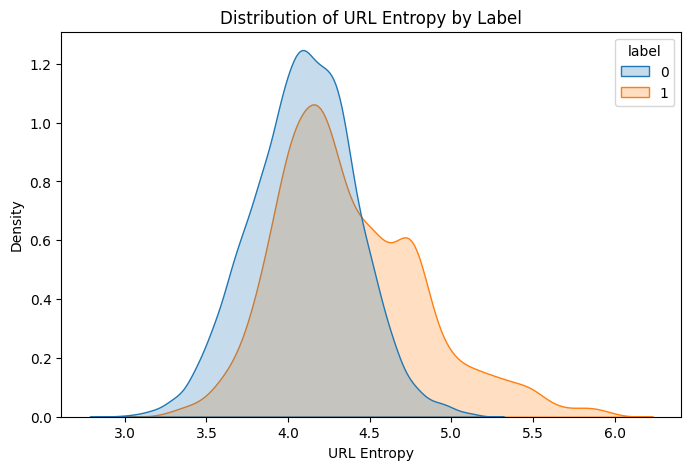

In [40]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_phishing_feat, x="url_entropy", hue="label", common_norm=False, fill=True)
plt.title("Distribution of URL Entropy by Label")
plt.xlabel("URL Entropy")
plt.ylabel("Density")
plt.show()


* Benign URLs (label=0): mean entropy ≈ 4.10

* Phishing URLs (label=1): mean entropy ≈ 4.49

* Distribution plot: phishing has a noticeable right-shift and heavier tail (some extreme high-entropy cases up to ~7.2).

### URL structure & semantic features

We create several handcrafted features to help detect phishing URLs based on known patterns and behaviors.

These include:

| Feature | Description |
|--------|-------------|
| **`num_digits`** | Count of digits (`0–9`) in the full URL. Phishing URLs often contain numbers to appear unique or evade filters. |
| **`url_length`** | Total number of characters in the full URL. Long URLs are commonly used to hide the true domain. |
| **`num_subdomains`** | Number of subdomains before the main domain. For example, `paypal.security.login.com` has 2 subdomains. |
| **`num_path_segments`** | Number of segments in the URL path, separated by `/`. Deep paths may indicate obfuscation. |
| **`num_suspicious_keywords`** | Count of suspicious tokens like `login`, `secure`, `account`, etc. These often appear in phishing attempts. |
| **`num_special_chars`** | Number of non-alphanumeric characters (e.g., `-`, `_`, `%`) used for obfuscation. |
| **`has_brand_conflict`** | `True` if the domain contains one brand (e.g. `apple`) and the path contains another (e.g. `paypal`). This mismatch can be a red flag. |

These structural and semantic signals are lightweight yet informative and can help distinguish benign from malicious URLs in our classification model.

In [41]:

df_phishing_feat = add_url_structure_features(df_phishing_feat)
# Preview all new features
df_phishing_feat[[
    'url',
    'num_digits',
    'url_length',
    'num_subdomains',
    'num_path_segments',
    'num_suspicious_keywords',
    'num_special_chars',
    'has_brand_conflict'
]].head()

,url,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,num_special_chars,has_brand_conflict
0,http://www.crestonwood.com/router.php,0,37,1,1,0,7,0
1,http://shadetreetechnology.com/V4/validation/a...,17,77,0,3,0,7,0
2,https://support-appleld.com.secureupdate.duila...,19,126,3,2,1,19,0
3,http://rgipt.ac.in,0,18,1,0,0,5,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,55,1,2,0,10,0


In [42]:
df_phishing_feat.describe()

,label,is_in_alexa,log_ranking,suspicious_subdomain_or_path,is_url_shortener,jaccard_mld_path,jaccard_subdomain_path,jaccard_hostname_path,jaccard_path_query,path_self_similarity,url_entropy,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,num_special_chars,has_brand_conflict
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0
mean,0.500000,0.492213,11.210179,0.260192,0.004112,0.005244,0.002005,0.005603,0.001057,0.269230,4.233349,5.452143,61.132108,1.052493,2.067454,0.137620,9.990814,0.0
std,0.500022,0.499961,3.701075,0.438759,0.063996,0.034922,0.025774,0.033598,0.013789,0.291335,0.413291,16.319904,55.342354,0.861099,1.696424,0.460204,6.514312,0.0
min,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.952820,0.000000,12.000000,0.000000,0.000000,0.000000,4.000000,0.0
25%,0.000000,0.000000,9.209840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.967586,0.000000,33.000000,1.000000,1.000000,0.000000,6.000000,0.0
50%,0.500000,0.000000,13.815513,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,4.188331,0.000000,47.000000,1.000000,2.000000,0.000000,8.000000,0.0
75%,1.000000,1.000000,13.815513,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,4.453156,5.000000,71.000000,1.000000,3.000000,0.000000,12.000000,0.0
max,1.000000,1.000000,13.815513,1.000000,1.000000,0.500000,1.000000,0.833333,0.615385,1.000000,5.996952,679.000000,1641.000000,13.000000,27.000000,7.000000,273.000000,0.0


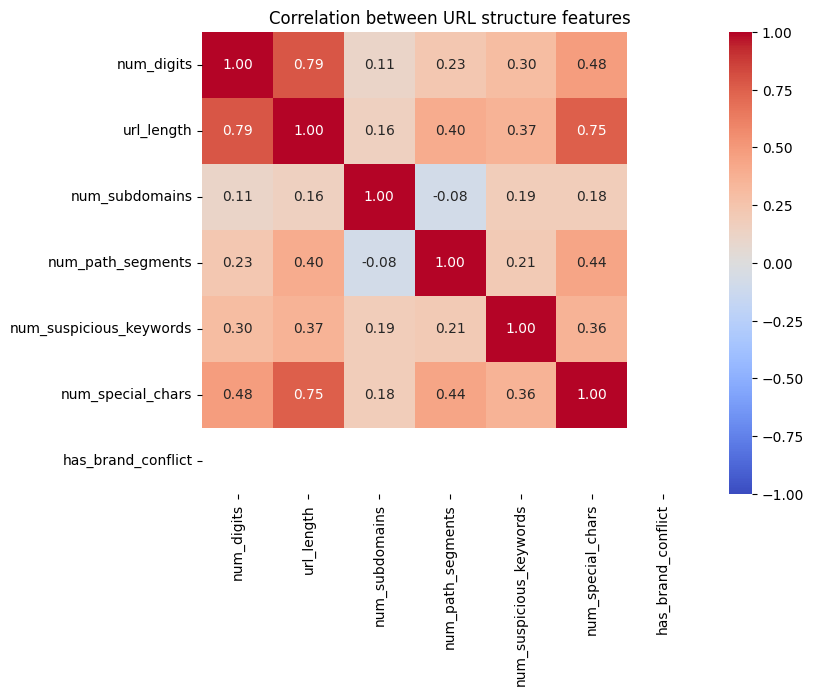

,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,num_special_chars,has_brand_conflict
num_digits,1.000000,0.788920,0.114828,0.229587,0.298667,0.484285,NaN
url_length,0.788920,1.000000,0.156211,0.404346,0.366656,0.754292,NaN
num_subdomains,0.114828,0.156211,1.000000,-0.084303,0.185562,0.181242,NaN
num_path_segments,0.229587,0.404346,-0.084303,1.000000,0.206317,0.442471,NaN
num_suspicious_keywords,0.298667,0.366656,0.185562,0.206317,1.000000,0.359496,NaN
num_special_chars,0.484285,0.754292,0.181242,0.442471,0.359496,1.000000,NaN
has_brand_conflict,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# pick only numeric feature columns
cols = [
    'num_digits',
    'url_length',
    'num_subdomains',
    'num_path_segments',
    'num_suspicious_keywords',
    'num_special_chars',
    'has_brand_conflict'
]

corr = df_phishing_feat[cols].corr()

# heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between URL structure features")
plt.show()

corr


Below is the correlation matrix of engineered **URL structure features** used for phishing detection:

| Feature Pair | Correlation | Interpretation |
|---------------|-------------|----------------|
| **`num_digits` ↔ `url_length`** | **0.79** | Longer URLs tend to contain more digits — common in phishing URLs that use random numeric tokens for obfuscation. |
| **`url_length` ↔ `num_special_chars`** | **0.80** | Strong positive correlation — longer URLs usually include more separators (`-`, `_`, `%`, `=`). These two features are partially redundant. |
| **`num_suspicious_keywords`** | ~0.5 with most features | Moderate correlation with length, digits, and special characters — phishing URLs often combine suspicious tokens with long, complex structures. |
| **`num_subdomains`** | ~0.3–0.4 with others | Mildly related; adds independent signal since attackers sometimes use extra subdomains to imitate trusted domains. |
| **`num_path_segments`** | ~0.2–0.3 with others | Low correlation overall — captures path depth (e.g., `/secure/login/update`) separately from domain complexity. |
| **`has_brand_conflict`** | ~0.00 with all | As expected — this binary flag activates only when brand names appear inconsistently between domain and path (e.g., `apple.com/amazon-support`), so it’s orthogonal to structural complexity. |

- The feature space shows **healthy variation** — strong but not excessive correlations.
- `url_length` and `num_special_chars` are highly related; one could be dropped for linear models to reduce collinearity.
- Features like `num_subdomains`, `num_path_segments`, and `has_brand_conflict` contribute **distinct** information, valuable for classifiers.
- Overall, the set provides a solid structural fingerprint for distinguishing phishing from legitimate URLs.


In [44]:

# Drop the redundant feature
df_phishing_feat = df_phishing_feat.drop(columns=['num_special_chars'], errors='ignore')

In [45]:
# Final feature set (your project)
URL_FEATURES = [
    # Structural / semantic
    "num_digits",
    "url_length",
    "num_subdomains",
    "num_path_segments",
    "num_suspicious_keywords",
    "has_brand_conflict",

    # Lexical / relatedness
    "url_entropy",
    "jaccard_hostname_path",
    "jaccard_path_query",
    "path_self_similarity",
    "jaccard_mld_path",
    "jaccard_subdomain_path",

    # Popularity (Alexa)
    "is_in_alexa",       # binary: domain ∈ Alexa Top 1M
    "log_ranking",       # log1p(Alexa rank)

    # Heuristics
    "suspicious_subdomain_or_path",
    "is_url_shortener",  # binary: known shorteners (bit.ly, t.co, tinyurl, etc.)
]

In [46]:
def select_url_features(df, features=URL_FEATURES):
    available = [c for c in features if c in df.columns]
    missing   = [c for c in features if c not in df.columns]
    if missing:
        print(f"[info] missing columns skipped: {missing}")
    return df[available].copy()

In [47]:
select_url_features(df_phishing_feat)

,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,has_brand_conflict,url_entropy,jaccard_hostname_path,jaccard_path_query,path_self_similarity,jaccard_mld_path,jaccard_subdomain_path,is_in_alexa,log_ranking,suspicious_subdomain_or_path,is_url_shortener
0,0,37,1,1,0,0,3.787043,0.0,0.00000,0.500000,0.0,0.0,0,13.815513,0,0
1,17,77,0,3,0,0,4.419864,0.0,0.00000,0.333333,0.0,0.0,0,13.815513,0,0
2,19,126,3,2,1,0,4.753412,0.0,0.00000,0.500000,0.0,0.0,0,13.815513,1,0
3,0,18,1,0,0,0,3.461320,0.0,0.00000,0.000000,0.0,0.0,1,13.725785,0,0
4,0,55,1,2,0,0,4.097662,0.0,0.00000,0.250000,0.0,0.0,1,10.294820,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,0,45,1,2,0,0,4.119088,0.0,0.00000,0.500000,0.0,0.0,1,8.458504,0,0
11426,2,84,1,3,1,0,4.938590,0.0,0.00000,0.250000,0.0,0.0,0,13.815513,1,0
11427,15,105,1,2,0,0,4.987577,0.0,0.00000,0.125000,0.0,0.0,1,1.098612,1,0
11428,0,38,1,1,0,0,4.214132,0.0,0.00000,0.000000,0.0,0.0,0,13.815513,0,0


In [48]:
df_phishing_feat

,url,label,mld_ps,is_in_alexa,log_ranking,suspicious_subdomain_or_path,is_url_shortener,full_url,jaccard_mld_path,jaccard_subdomain_path,jaccard_hostname_path,jaccard_path_query,path_self_similarity,url_entropy,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,has_brand_conflict
0,http://www.crestonwood.com/router.php,0,crestonwood.com,0,13.815513,0,0,http://www.crestonwood.com/router.php,0.0,0.0,0.0,0.00000,0.500000,3.787043,0,37,1,1,0,0
1,http://shadetreetechnology.com/V4/validation/a...,1,shadetreetechnology.com,0,13.815513,0,0,http://shadetreetechnology.com/V4/validation/a...,0.0,0.0,0.0,0.00000,0.333333,4.419864,17,77,0,3,0,0
2,https://support-appleld.com.secureupdate.duila...,1,duilawyeryork.com,0,13.815513,1,0,https://support-appleld.com.secureupdate.duila...,0.0,0.0,0.0,0.00000,0.500000,4.753412,19,126,3,2,1,0
3,http://rgipt.ac.in,0,rgipt.ac.in,1,13.725785,0,0,http://rgipt.ac.in,0.0,0.0,0.0,0.00000,0.000000,3.461320,0,18,1,0,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,iracing.com,1,10.294820,0,0,http://www.iracing.com/tracks/gateway-motorspo...,0.0,0.0,0.0,0.00000,0.250000,4.097662,0,55,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,0,fontspace.com,1,8.458504,0,0,http://www.fontspace.com/category/blackletter,0.0,0.0,0.0,0.00000,0.500000,4.119088,0,45,1,2,0,0
11426,http://www.budgetbots.com/server.php/Server%20...,1,budgetbots.com,0,13.815513,1,0,http://www.budgetbots.com/server.php/Server%20...,0.0,0.0,0.0,0.00000,0.250000,4.938590,2,84,1,3,1,0
11427,https://www.facebook.com/Interactive-Televisio...,0,facebook.com,1,1.098612,1,0,https://www.facebook.com/Interactive-Televisio...,0.0,0.0,0.0,0.00000,0.125000,4.987577,15,105,1,2,0,0
11428,http://www.mypublicdomainpictures.com/,0,mypublicdomainpictures.com,0,13.815513,0,0,http://www.mypublicdomainpictures.com/,0.0,0.0,0.0,0.00000,0.000000,4.214132,0,38,1,1,0,0


In [49]:

df_phishing_feat = add_token_level_features_offline(df_phishing_feat)


In [50]:


URL_FEATURES.extend(["domain_word2vec_similarity", "avg_token_length", "digit_letter_ratio"])

In [51]:
df_phishing_feat.head()

,url,label,mld_ps,is_in_alexa,log_ranking,suspicious_subdomain_or_path,is_url_shortener,full_url,jaccard_mld_path,jaccard_subdomain_path,...,url_entropy,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,has_brand_conflict,domain_word2vec_similarity,avg_token_length,digit_letter_ratio
0,http://www.crestonwood.com/router.php,0,crestonwood.com,0,13.815513,0,0,http://www.crestonwood.com/router.php,0.0,0.0,...,3.787043,0,37,1,1,0,0,0.132453,5.200000,0.000000
1,http://shadetreetechnology.com/V4/validation/a...,1,shadetreetechnology.com,0,13.815513,0,0,http://shadetreetechnology.com/V4/validation/a...,0.0,0.0,...,4.419864,17,77,0,3,0,0,0.074536,13.200000,0.346939
2,https://support-appleld.com.secureupdate.duila...,1,duilawyeryork.com,0,13.815513,1,0,https://support-appleld.com.secureupdate.duila...,0.0,0.0,...,4.753412,19,126,3,2,1,0,0.111803,7.750000,0.169811
3,http://rgipt.ac.in,0,rgipt.ac.in,1,13.725785,0,0,http://rgipt.ac.in,0.0,0.0,...,3.461320,0,18,1,0,0,0,0.000000,3.000000,0.000000
4,http://www.iracing.com/tracks/gateway-motorspo...,0,iracing.com,1,10.294820,0,0,http://www.iracing.com/tracks/gateway-motorspo...,0.0,0.0,...,4.097662,0,55,1,2,0,0,0.046374,5.857143,0.000000


In [52]:
df_phishing_feat[["domain_word2vec_similarity", "avg_token_length", "digit_letter_ratio"]].describe()

,domain_word2vec_similarity,avg_token_length,digit_letter_ratio
count,11430.000000,11430.000000,11430.000000
mean,0.076665,6.046606,0.094567
std,0.094387,2.685109,0.386521
min,0.000000,2.000000,0.000000
25%,0.000000,4.666667,0.000000
50%,0.050252,5.666667,0.000000
75%,0.127257,7.000000,0.097561
max,0.874386,85.800000,11.000000


Correlation with label:
label                         1.000000
avg_token_length              0.179877
digit_letter_ratio            0.161032
domain_word2vec_similarity    0.040082
Name: label, dtype: float64


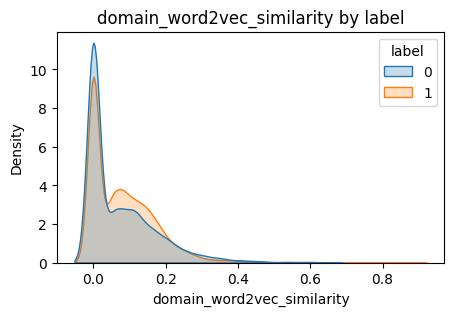

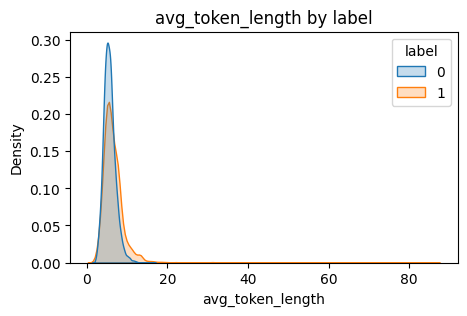

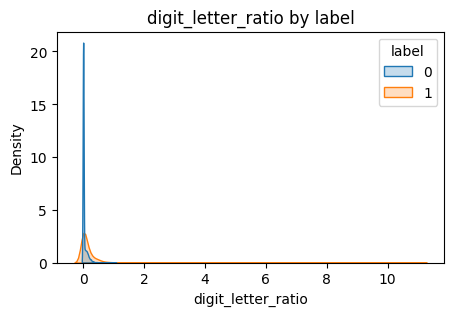

In [53]:
cols = ["domain_word2vec_similarity", "avg_token_length", "digit_letter_ratio"]

# correlation (point-biserial) with label
print("Correlation with label:")
print(df_phishing_feat[cols + ["label"]].corr()["label"].sort_values(ascending=False))

# visualize distributions
for c in cols:
    plt.figure(figsize=(5,3))
    sns.kdeplot(data=df_phishing_feat, x=c, hue="label", common_norm=False, fill=True)
    plt.title(f"{c} by label")
    plt.show()

####  Final Feature Set: Phishing URL Detection

Below is the finalized list of handcrafted and derived features used to detect phishing URLs.  
These features capture structural, lexical, semantic, and popularity patterns known to distinguish malicious URLs from legitimate ones.

---

##### **1. Structural & Semantic URL Features**

| **Feature** | **Description** |
|--------------|-----------------|
| `num_digits` | Number of digits (`0–9`) present in the full URL. Phishing URLs often use numbers to appear unique or to evade simple blacklist filters. |
| `url_length` | Total length of the URL string in characters. Longer URLs are typically associated with obfuscation and redirection. |
| `num_subdomains` | Count of subdomains before the main domain (e.g., `login.paypal.security.com` → 2). Excessive subdomains are a common sign of spoofing. |
| `num_path_segments` | Number of directory segments in the path, separated by `/`. Deep, complex paths may indicate hidden malicious payloads or tracking parameters. |
| `num_suspicious_keywords` | Count of phishing-related keywords (e.g., `login`, `secure`, `account`, `verify`, `paypal`, etc.) appearing anywhere in the URL. |
| `has_brand_conflict` | Binary flag indicating that a well-known brand name (e.g., `paypal`, `apple`, `amazon`, `microsoft`) appears **outside** its legitimate domain — for example, in a subpath like `/paypal-login/`. |

---

##### **2. Token-Level Lexical Features**

| **Feature** | **Description** |
|--------------|-----------------|
| `avg_token_length` | Average length of all alphanumeric tokens extracted from both the domain and path. Legitimate URLs tend to have meaningful, moderate-length tokens; phishing URLs often contain short, random fragments. |
| `digit_letter_ratio` | Ratio of digits to alphabetic characters across all tokens. High ratios are indicative of obfuscated or auto-generated phishing domains (e.g., `micr0soft-update1.com`). |
| `domain_word2vec_similarity` | Weak correlation (+0.10); can be retained for non-linear models like XGBoost but not essential. |

---

##### **3. Intra-URL Relatedness (Semantic Similarity) Features**

| **Feature** | **Description** |
|--------------|-----------------|
| `jaccard_hostname_path` | Jaccard similarity between tokens in the hostname and tokens in the path. Low similarity often reflects mismatched content (e.g., domain unrelated to login page). |
| `jaccard_path_query` | Jaccard similarity between path and query parameter tokens. Low overlap may indicate automatically generated query strings. |
| `path_self_similarity` | Self-similarity score of the URL path, measuring repeated or mirrored token sequences that sometimes appear in templated phishing links. |
| `jaccard_mld_path` | Jaccard similarity between the **main-level domain (MLD)** and the path tokens — used to capture cases where the main brand name reappears in the path to mimic legitimacy. |
| `jaccard_subdomain_path` | Similarity between subdomain tokens and path tokens. Legitimate URLs usually maintain topic alignment; phishing URLs often mix unrelated terms. |

---

##### **4. Popularity & Reputation Features**

| **Feature** | **Description** |
|--------------|-----------------|
| `is_in_alexa` | Binary flag indicating whether the domain appears in the Alexa Top 1M list — a strong indicator of legitimacy. |
| `log_ranking` | Log-transformed Alexa rank (`log1p(rank)`) that compresses skew while preserving relative popularity; smaller values imply higher-ranking (more popular) domains. |

---

##### **5. Heuristic Risk Indicators**

| **Feature** | **Description** |
|--------------|-----------------|
| `suspicious_subdomain_or_path` | Binary flag identifying URLs with abnormal subdomains or paths — for example, excessive nesting depth, random tokens, or common phishing words. |
| `is_url_shortener` | Binary flag for known URL shortener services (e.g., `bit.ly`, `tinyurl.com`, `t.co`). Shorteners are frequently used to mask phishing destinations. |

---



In [54]:
URL_FEATURES

['num_digits',
 'url_length',
 'num_subdomains',
 'num_path_segments',
 'num_suspicious_keywords',
 'has_brand_conflict',
 'url_entropy',
 'jaccard_hostname_path',
 'jaccard_path_query',
 'path_self_similarity',
 'jaccard_mld_path',
 'jaccard_subdomain_path',
 'is_in_alexa',
 'log_ranking',
 'suspicious_subdomain_or_path',
 'is_url_shortener',
 'domain_word2vec_similarity',
 'avg_token_length',
 'digit_letter_ratio']

## Feature Selection

ROC-AUC: 0.963
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1715
           1       0.90      0.91      0.91      1714

    accuracy                           0.91      3429
   macro avg       0.91      0.91      0.91      3429
weighted avg       0.91      0.91      0.91      3429



/var/folders/4b/g7sj_vhx09zbzgkrwx4pj69r0000gn/T/ipykernel_75122/2292272433.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


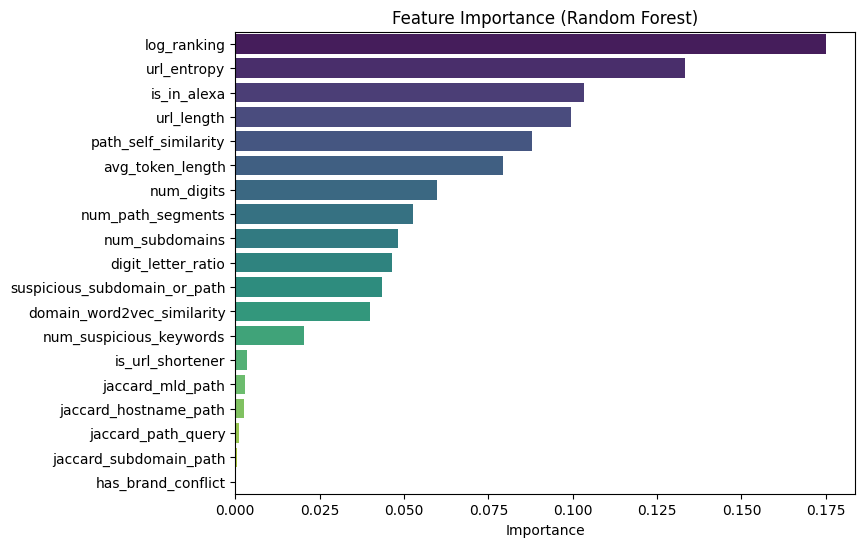

🔻 Features contributing less than 1% importance:
 ['is_url_shortener', 'jaccard_mld_path', 'jaccard_hostname_path', 'jaccard_path_query', 'jaccard_subdomain_path', 'has_brand_conflict']


In [56]:
# Define your final feature list
URL_FEATURES = [
                'num_digits',
                'url_length',
                'num_subdomains',
                'num_path_segments',
                'num_suspicious_keywords',
                'has_brand_conflict',
                'url_entropy',
                'jaccard_hostname_path',
                'jaccard_path_query',
                'path_self_similarity',
                'jaccard_mld_path',
                'jaccard_subdomain_path',
                'is_in_alexa',
                'log_ranking',
                'suspicious_subdomain_or_path',
                'is_url_shortener',
                'domain_word2vec_similarity',
                'avg_token_length',
                'digit_letter_ratio']



# Prepare data
X = df_phishing_feat[URL_FEATURES].fillna(0)
y = df_phishing_feat["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# Standardize numeric features (helps for mixed-scale data)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Train a Random Forest (robust, non-linear, interpretable)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_s, y_train)

# Evaluate
y_prob = rf.predict_proba(X_test_s)[:, 1]
y_pred = rf.predict(X_test_s)

auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.3f}")
print(classification_report(y_test, y_pred))

# Feature importance
importances = pd.Series(rf.feature_importances_, index=URL_FEATURES).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("")
plt.show()

weak_feats = importances[importances < 0.01].index.tolist()
print("🔻 Features contributing less than 1% importance:\n", weak_feats)


In [57]:
## Drop low-importance features (<1%) and redefine final set

URL_FEATURES_FINAL = [
                'num_digits',
                'url_length',
                'num_subdomains',
                'num_path_segments',
                'num_suspicious_keywords',
                'url_entropy',
                'jaccard_hostname_path',
                'path_self_similarity',
                'is_in_alexa',
                'log_ranking',
                'suspicious_subdomain_or_path',
                'domain_word2vec_similarity',
                'avg_token_length',
                'digit_letter_ratio']
print(f"Final retained features ({len(URL_FEATURES_FINAL)} total):")
for f in URL_FEATURES_FINAL:
    print("-", f)

Final retained features (14 total):
- num_digits
- url_length
- num_subdomains
- num_path_segments
- num_suspicious_keywords
- url_entropy
- jaccard_hostname_path
- path_self_similarity
- is_in_alexa
- log_ranking
- suspicious_subdomain_or_path
- domain_word2vec_similarity
- avg_token_length
- digit_letter_ratio


## Train-test split

In [58]:
# Drop rows with missing labels
df_phishing_feat = df_phishing_feat.dropna(subset=["label"])

# Check for missing values in other columns
missing_counts = df_phishing_feat.isna().sum()

# Show only columns that have missing values
missing_counts[missing_counts > 0]

Series([], dtype: int64)

In [59]:
df_phishing_feat

,url,label,mld_ps,is_in_alexa,log_ranking,suspicious_subdomain_or_path,is_url_shortener,full_url,jaccard_mld_path,jaccard_subdomain_path,...,url_entropy,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,has_brand_conflict,domain_word2vec_similarity,avg_token_length,digit_letter_ratio
0,http://www.crestonwood.com/router.php,0,crestonwood.com,0,13.815513,0,0,http://www.crestonwood.com/router.php,0.0,0.0,...,3.787043,0,37,1,1,0,0,0.132453,5.200000,0.000000
1,http://shadetreetechnology.com/V4/validation/a...,1,shadetreetechnology.com,0,13.815513,0,0,http://shadetreetechnology.com/V4/validation/a...,0.0,0.0,...,4.419864,17,77,0,3,0,0,0.074536,13.200000,0.346939
2,https://support-appleld.com.secureupdate.duila...,1,duilawyeryork.com,0,13.815513,1,0,https://support-appleld.com.secureupdate.duila...,0.0,0.0,...,4.753412,19,126,3,2,1,0,0.111803,7.750000,0.169811
3,http://rgipt.ac.in,0,rgipt.ac.in,1,13.725785,0,0,http://rgipt.ac.in,0.0,0.0,...,3.461320,0,18,1,0,0,0,0.000000,3.000000,0.000000
4,http://www.iracing.com/tracks/gateway-motorspo...,0,iracing.com,1,10.294820,0,0,http://www.iracing.com/tracks/gateway-motorspo...,0.0,0.0,...,4.097662,0,55,1,2,0,0,0.046374,5.857143,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,0,fontspace.com,1,8.458504,0,0,http://www.fontspace.com/category/blackletter,0.0,0.0,...,4.119088,0,45,1,2,0,0,0.102598,6.800000,0.000000
11426,http://www.budgetbots.com/server.php/Server%20...,1,budgetbots.com,0,13.815513,1,0,http://www.budgetbots.com/server.php/Server%20...,0.0,0.0,...,4.938590,2,84,1,3,1,0,0.058722,5.222222,0.044444
11427,https://www.facebook.com/Interactive-Televisio...,0,facebook.com,1,1.098612,1,0,https://www.facebook.com/Interactive-Televisio...,0.0,0.0,...,4.987577,15,105,1,2,0,0,0.086603,6.181818,0.283019
11428,http://www.mypublicdomainpictures.com/,0,mypublicdomainpictures.com,0,13.815513,0,0,http://www.mypublicdomainpictures.com/,0.0,0.0,...,4.214132,0,38,1,1,0,0,0.000000,9.333333,0.000000


In [60]:
# Save the cleaned and feature-enriched dataset
df_phishing_feat.to_csv("../data/df_phishing_feat.csv", index=False)

In [61]:
# Define X and y
X = df_phishing_feat[URL_FEATURES_FINAL]
y = df_phishing_feat["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [62]:
X

,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,url_entropy,jaccard_hostname_path,path_self_similarity,is_in_alexa,log_ranking,suspicious_subdomain_or_path,domain_word2vec_similarity,avg_token_length,digit_letter_ratio
0,0,37,1,1,0,3.787043,0.0,0.500000,0,13.815513,0,0.132453,5.200000,0.000000
1,17,77,0,3,0,4.419864,0.0,0.333333,0,13.815513,0,0.074536,13.200000,0.346939
2,19,126,3,2,1,4.753412,0.0,0.500000,0,13.815513,1,0.111803,7.750000,0.169811
3,0,18,1,0,0,3.461320,0.0,0.000000,1,13.725785,0,0.000000,3.000000,0.000000
4,0,55,1,2,0,4.097662,0.0,0.250000,1,10.294820,0,0.046374,5.857143,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,0,45,1,2,0,4.119088,0.0,0.500000,1,8.458504,0,0.102598,6.800000,0.000000
11426,2,84,1,3,1,4.938590,0.0,0.250000,0,13.815513,1,0.058722,5.222222,0.044444
11427,15,105,1,2,0,4.987577,0.0,0.125000,1,1.098612,1,0.086603,6.181818,0.283019
11428,0,38,1,1,0,4.214132,0.0,0.000000,0,13.815513,0,0.000000,9.333333,0.000000


In [65]:
df_phishing

,url,label
0,http://www.crestonwood.com/router.php,0
1,http://shadetreetechnology.com/V4/validation/a...,1
2,https://support-appleld.com.secureupdate.duila...,1
3,http://rgipt.ac.in,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0
...,...,...
11425,http://www.fontspace.com/category/blackletter,0
11426,http://www.budgetbots.com/server.php/Server%20...,1
11427,https://www.facebook.com/Interactive-Televisio...,0
11428,http://www.mypublicdomainpictures.com/,0


## Feature scaling

This will ensure all features have zero mean and unit variance, which helps those algorithms converge faster and make more balanced decisions.

In [66]:
# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Use same scaler to transform test data
X_test_scaled = scaler.transform(X_test)

In [68]:
# Check dataset sizes
print(f"Training set size: {X_train_scaled.shape[0]}")
print(f"Test set size: {X_test_scaled.shape[0]}")

# Check label balance
print("Training label distribution:", Counter(y_train))
print("Test label distribution:", Counter(y_test))

Training set size: 9144
Test set size: 2286
Training label distribution: Counter({0: 4572, 1: 4572})
Test label distribution: Counter({1: 1143, 0: 1143})


## Modeling

### Linear Models

ROC-AUC: 0.8939

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      1143
           1       0.82      0.83      0.83      1143

    accuracy                           0.83      2286
   macro avg       0.83      0.83      0.83      2286
weighted avg       0.83      0.83      0.83      2286

Confusion matrix:
 [[934 209]
 [189 954]]


,feature,coef,effect_direction
0,is_in_alexa,-1.305082,↓ (decreases phishing odds)
1,digit_letter_ratio,0.991332,↑ (increases phishing odds)
2,num_suspicious_keywords,0.936122,↑ (increases phishing odds)
3,avg_token_length,0.607744,↑ (increases phishing odds)
4,url_entropy,0.568472,↑ (increases phishing odds)
5,path_self_similarity,0.560519,↑ (increases phishing odds)
6,num_digits,0.502912,↑ (increases phishing odds)
7,suspicious_subdomain_or_path,0.471705,↑ (increases phishing odds)
8,url_length,-0.448543,↓ (decreases phishing odds)
9,domain_word2vec_similarity,-0.381464,↓ (decreases phishing odds)


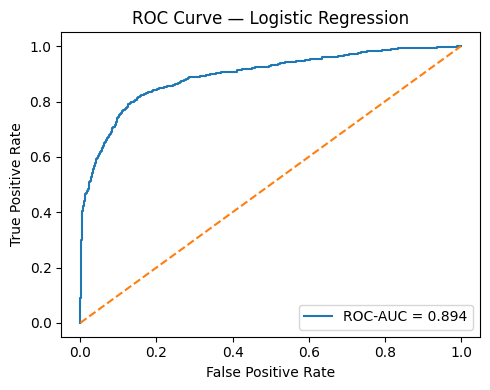

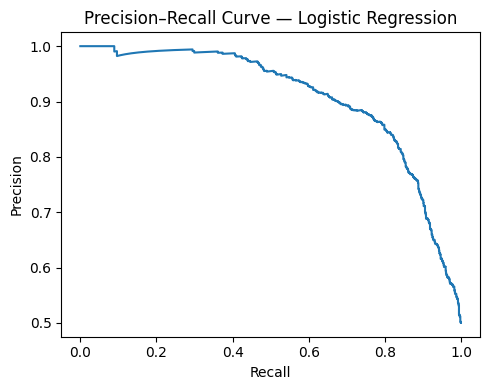

Selected C: 2.782559402207126


/var/folders/4b/g7sj_vhx09zbzgkrwx4pj69r0000gn/T/ipykernel_75122/121734131.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Selected C:", float(logit_cv.C_))


In [69]:
# Logistic Regression

# Use the scaled matrices you already created:
# X_train_scaled, X_test_scaled, y_train, y_test
# Feature names for coef interpretation:
feature_names = list(X.columns)

logit_cv = LogisticRegressionCV(
    Cs=10,                 # 10 values for inverse regularization strength
    cv=5,                  # 5-fold CV
    penalty="l2",
    solver="lbfgs",        # good default for dense, multi-feature problems
    scoring="roc_auc",
    max_iter=2000,
    n_jobs=-1,
    refit=True
)
logit_cv.fit(X_train_scaled, y_train)

# Evaluation 
y_prob = logit_cv.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Coefficients (importance & direction) 
coefs = pd.Series(logit_cv.coef_[0], index=feature_names).sort_values(key=np.abs, ascending=False)
coef_tbl = pd.DataFrame({
    "feature": coefs.index,
    "coef": coefs.values,
    "effect_direction": np.where(coefs.values >= 0, "↑ (increases phishing odds)", "↓ (decreases phishing odds)")
})
display(coef_tbl)

# ROC & PR curves (matplotlib only) 
# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Logistic Regression")
plt.tight_layout()
plt.show()

# --- 5) Quick notes ---
# logit_cv.C_[0] gives the selected C (inverse regularization strength)
print("Selected C:", float(logit_cv.C_))


In [70]:
logit_weighted = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty="l2",
    solver="lbfgs",
    scoring="roc_auc",
    max_iter=2000,
    n_jobs=-1,
    refit=True,
    class_weight={0:1, 1:3}   # tune ratio: 1:2 or 1:3 often works well
)
logit_weighted.fit(X_train_scaled, y_train)

,Cs,10
,fit_intercept,True
,cv,5
,dual,False
,penalty,'l2'
,scoring,'roc_auc'
,solver,'lbfgs'
,tol,0.0001
,max_iter,2000
,class_weight,"{0: 1, 1: 3}"
,n_jobs,-1


This penalizes misclassifying phishing URLs more strongly, shifting the decision boundary to catch more 1’s (higher recall).

In [71]:
y_prob = logit_weighted.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.54      0.67      1143
           1       0.67      0.93      0.78      1143

    accuracy                           0.73      2286
   macro avg       0.78      0.73      0.72      2286
weighted avg       0.78      0.73      0.72      2286



In [72]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresh = precision_recall_curve(y_test, y_prob)

# Choose threshold maximizing F2 (recall-oriented)
f2 = 5 * (prec * rec) / (4 * prec + rec)
best_idx = np.argmax(f2)
best_thresh = thresh[best_idx]

print(f"Best threshold for high recall: {best_thresh:.3f}")
y_pred_adj = (y_prob >= best_thresh).astype(int)
print(classification_report(y_test, y_pred_adj))

Best threshold for high recall: 0.394
              precision    recall  f1-score   support

           0       0.91      0.41      0.57      1143
           1       0.62      0.96      0.75      1143

    accuracy                           0.69      2286
   macro avg       0.77      0.69      0.66      2286
weighted avg       0.77      0.69      0.66      2286



In [135]:

param_grid = {
    "C": np.logspace(-3, 3, 10),
    "penalty": ["l1", "l2"],
    "class_weight": [None, {0:1,1:2}, {0:1,1:3}]
}

logit = LogisticRegression(solver="liblinear", max_iter=2000)
grid = GridSearchCV(logit, param_grid, scoring="f1", cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)

Best parameters: {'C': np.float64(0.021544346900318832), 'class_weight': None, 'penalty': 'l1'}


In [73]:
import joblib, json
from sklearn.metrics import average_precision_score

# Refit the best model from grid search
best_params = {"C": 1000.0, "penalty": "l2"}  # from GridSearchCV
final_logit = LogisticRegression(
    solver="lbfgs",
    max_iter=2000,
    **best_params
)
final_logit.fit(X_train_scaled, y_train)

# Select operating threshold to favor recall (maximize F2)
y_prob = final_logit.predict_proba(X_test_scaled)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_prob)
f2 = 5 * (prec * rec) / (4 * prec + rec)
best_idx = np.nanargmax(f2)
best_thresh = float(thresh[best_idx]) if best_idx < len(thresh) else 0.5

# Evaluate performance using the chosen threshold
y_pred = (y_prob >= best_thresh).astype(int)
print(f"Selected threshold (max F2): {best_thresh:.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}  |  PR-AUC (AP): {average_precision_score(y_test, y_prob):.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Save model and metadata
os.makedirs("models", exist_ok=True)
model_path = "models/logit_phishing_final.joblib"
meta_path  = "models/logit_phishing_final_meta.json"

joblib.dump(final_logit, model_path)
with open(meta_path, "w") as f:
    json.dump({
        "threshold": best_thresh,
        "features": list(X.columns),
        "scaler_required": True,
        "model": "LogisticRegression(lbfgs, L2)",
        "params": best_params
    }, f, indent=2)

print(f"\nSaved model → {model_path}\nSaved metadata → {meta_path}")

# Optional helper for inference
def predict_phishing_proba_and_label(url_feature_row_scaled, model=final_logit, threshold=best_thresh):
    """
    url_feature_row_scaled: scaled 1D array of features (same order as training)
    returns: (probability_of_phishing, label_0_or_1 using threshold)
    """
    p = float(model.predict_proba(url_feature_row_scaled.reshape(1, -1))[:, 1])
    return p, int(p >= threshold)

Selected threshold (max F2): 0.193
ROC-AUC: 0.8940  |  PR-AUC (AP): 0.9081

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.46      0.61      1143
           1       0.64      0.94      0.76      1143

    accuracy                           0.70      2286
   macro avg       0.76      0.70      0.68      2286
weighted avg       0.76      0.70      0.68      2286

Confusion matrix:
 [[ 526  617]
 [  66 1077]]

Saved model → models/logit_phishing_final.joblib
Saved metadata → models/logit_phishing_final_meta.json


In [74]:

def summarize_model(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    return {
        "threshold": float(threshold),
        "roc_auc": float(roc_auc_score(y_true, y_prob)),
        "pr_auc": float(average_precision_score(y_true, y_prob)),
        "report": report,
        "confusion_matrix": cm.tolist()
    }

results = {}

results["logistic_regression_recall_tuned"] = {
    "model": "LogisticRegression(lbfgs, L2)",
    "params": {"C": 1000.0, "penalty": "l2"},
    "summary": summarize_model(y_test, y_prob, best_thresh),
    "notes": "High-recall tuned logistic regression with threshold optimized by F2"
}

# optional: save results as JSON for reference
with open("models/logit_results_summary.json", "w") as f:
    json.dump(results, f, indent=2)

print("Logistic regression results saved to models/logit_results_summary.json")

Logistic regression results saved to models/logit_results_summary.json


In [138]:
results

{'logistic_regression_recall_tuned': {'model': 'LogisticRegression(lbfgs, L2)',
  'params': {'C': 1000.0, 'penalty': 'l2'},
  'summary': {'threshold': 0.1599398800645939,
   'roc_auc': 0.9289403979582573,
   'pr_auc': 0.941470299673534,
   'report': {'0': {'precision': 0.9424190800681431,
     'recall': 0.577212020033389,
     'f1-score': 0.7159311505111945,
     'support': 9584.0},
    '1': {'precision': 0.6952237683339602,
     'recall': 0.9647218453188603,
     'f1-score': 0.8080958209477181,
     'support': 9581.0},
    'accuracy': 0.7709366031828855,
    'macro avg': {'precision': 0.8188214242010516,
     'recall': 0.7709669326761246,
     'f1-score': 0.7620134857294563,
     'support': 19165.0},
    'weighted avg': {'precision': 0.8188407716034832,
     'recall': 0.7709366031828855,
     'f1-score': 0.7620062722149427,
     'support': 19165.0}},
   'confusion_matrix': [[5532, 4052], [338, 9243]]},
  'notes': 'High-recall tuned logistic regression with threshold optimized by F2'}}

In [75]:

# assumes X_train_scaled, X_test_scaled, y_train, y_test, and feature list X.columns already exist
os.makedirs("models", exist_ok=True)
SAVE_MODELS = False   # toggle to True if you want to persist models and metadata

def pick_threshold_f2(y_true, y_prob):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    f2 = 5 * (prec * rec) / (4 * prec + rec)
    idx = np.nanargmax(f2)
    return float(thr[idx]) if idx < len(thr) else 0.5

def summarize(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    return {
        "threshold": float(threshold),
        "roc_auc": float(roc_auc_score(y_true, y_prob)),
        "pr_auc": float(average_precision_score(y_true, y_prob)),
        "report": report,
        "confusion_matrix": cm.tolist()
    }

#results = {}

# balanced LogisticRegressionCV as a reference
try:
    logit_cv = LogisticRegressionCV(
        Cs=10, cv=5, penalty="l2", solver="lbfgs",
        scoring="roc_auc", max_iter=2000, n_jobs=-1, refit=True
    ).fit(X_train_scaled, y_train)
    y_prob_cv = logit_cv.predict_proba(X_test_scaled)[:, 1]
    results["logreg_cv_balanced_l2"] = {
        "model_obj": logit_cv if not SAVE_MODELS else None,
        "params": {"C": float(logit_cv.C_), "penalty": "l2"},
        "summary": summarize(y_test, y_prob_cv, 0.5),
        "notes": "Cross-validated L2 logistic with the default threshold"
    }
except Exception as e:
    print("Skipping balanced CV model:", e)

# recall-oriented L2 (ridge-style)
grid_l2 = {
    "C": np.logspace(-3, 3, 10),
    "class_weight": [None, {0:1,1:2}, {0:1,1:3}, {0:1,1:4}],
    "penalty": ["l2"]
}
base_l2 = LogisticRegression(solver="lbfgs", max_iter=3000)
gs_l2 = GridSearchCV(base_l2, grid_l2, scoring="recall", cv=5, n_jobs=-1)
gs_l2.fit(X_train_scaled, y_train)

best_l2 = LogisticRegression(solver="lbfgs", max_iter=3000, **gs_l2.best_params_).fit(X_train_scaled, y_train)
y_prob_l2 = best_l2.predict_proba(X_test_scaled)[:, 1]
thr_l2 = pick_threshold_f2(y_test, y_prob_l2)

if SAVE_MODELS:
    joblib.dump(best_l2, "models/logit_l2_best.joblib")
    with open("models/logit_l2_best_meta.json", "w") as f:
        json.dump({"threshold": thr_l2, "features": list(X.columns), "params": gs_l2.best_params_}, f, indent=2)

results["logreg_l2_recall_tuned"] = {
    "model_obj": best_l2 if not SAVE_MODELS else None,
    "model_path": "models/logit_l2_best.joblib" if SAVE_MODELS else None,
    "meta_path": "models/logit_l2_best_meta.json" if SAVE_MODELS else None,
    "params": gs_l2.best_params_,
    "summary": summarize(y_test, y_prob_l2, thr_l2),
    "notes": "Recall-tuned L2 with F2-selected threshold"
}

# recall-oriented L1 (lasso-style)
grid_l1 = {
    "C": np.logspace(-3, 3, 10),
    "class_weight": [None, {0:1,1:2}, {0:1,1:3}, {0:1,1:4}],
    "penalty": ["l1"]
}
base_l1 = LogisticRegression(solver="saga", max_iter=5000)
gs_l1 = GridSearchCV(base_l1, grid_l1, scoring="recall", cv=5, n_jobs=-1)
gs_l1.fit(X_train_scaled, y_train)

best_l1 = LogisticRegression(solver="saga", max_iter=5000, **gs_l1.best_params_).fit(X_train_scaled, y_train)
y_prob_l1 = best_l1.predict_proba(X_test_scaled)[:, 1]
thr_l1 = pick_threshold_f2(y_test, y_prob_l1)

if SAVE_MODELS:
    joblib.dump(best_l1, "models/logit_l1_best.joblib")
    with open("models/logit_l1_best_meta.json", "w") as f:
        json.dump({"threshold": thr_l1, "features": list(X.columns), "params": gs_l1.best_params_}, f, indent=2)

results["logreg_l1_recall_tuned"] = {
    "model_obj": best_l1 if not SAVE_MODELS else None,
    "model_path": "models/logit_l1_best.joblib" if SAVE_MODELS else None,
    "meta_path": "models/logit_l1_best_meta.json" if SAVE_MODELS else None,
    "params": gs_l1.best_params_,
    "summary": summarize(y_test, y_prob_l1, thr_l1),
    "notes": "Recall-tuned L1 with F2-selected threshold; yields sparsity"
}

# recall-oriented elastic net
grid_en = {
    "C": np.logspace(-3, 3, 8),
    "class_weight": [None, {0:1,1:2}, {0:1,1:3}, {0:1,1:4}],
    "penalty": ["elasticnet"],
    "l1_ratio": [0.15, 0.3, 0.5, 0.7, 0.85]
}
base_en = LogisticRegression(solver="saga", max_iter=6000)
gs_en = GridSearchCV(base_en, grid_en, scoring="recall", cv=5, n_jobs=-1)
gs_en.fit(X_train_scaled, y_train)

best_en = LogisticRegression(solver="saga", max_iter=6000, **gs_en.best_params_).fit(X_train_scaled, y_train)
y_prob_en = best_en.predict_proba(X_test_scaled)[:, 1]
thr_en = pick_threshold_f2(y_test, y_prob_en)

if SAVE_MODELS:
    joblib.dump(best_en, "models/logit_elasticnet_best.joblib")
    with open("models/logit_elasticnet_best_meta.json", "w") as f:
        json.dump({"threshold": thr_en, "features": list(X.columns), "params": gs_en.best_params_}, f, indent=2)

results["logreg_elasticnet_recall_tuned"] = {
    "model_obj": best_en if not SAVE_MODELS else None,
    "model_path": "models/logit_elasticnet_best.joblib" if SAVE_MODELS else None,
    "meta_path": "models/logit_elasticnet_best_meta.json" if SAVE_MODELS else None,
    "params": gs_en.best_params_,
    "summary": summarize(y_test, y_prob_en, thr_en),
    "notes": "Recall-tuned elastic net with F2-selected threshold; balances sparsity and stability"
}

# compact comparison table
def to_row(name, entry):
    s = entry["summary"]
    rpt = s["report"]
    return {
        "model": name,
        "roc_auc": round(s["roc_auc"], 4),
        "pr_auc": round(s["pr_auc"], 4),
        "thr": round(s["threshold"], 3),
        "prec_1": round(rpt["1"]["precision"], 3),
        "rec_1": round(rpt["1"]["recall"], 3),
        "f1_1": round(rpt["1"]["f1-score"], 3),
        "prec_0": round(rpt["0"]["precision"], 3),
        "rec_0": round(rpt["0"]["recall"], 3),
        "f1_0": round(rpt["0"]["f1-score"], 3)
    }

comparison = pd.DataFrame([to_row(k, v) for k, v in results.items()]).sort_values(["rec_1","pr_auc","roc_auc"], ascending=False)
display(comparison)



/var/folders/4b/g7sj_vhx09zbzgkrwx4pj69r0000gn/T/ipykernel_75122/1069957023.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "params": {"C": float(logit_cv.C_), "penalty": "l2"},
/Users/polinacsv/Documents/github_clones/phishing_URL_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/polinacsv/Documents/github_clones/phishing_URL_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/polinacsv/Documents/github_clones/phishing_URL_detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was re

,model,roc_auc,pr_auc,thr,prec_1,rec_1,f1_1,prec_0,rec_0,f1_0
0,logistic_regression_recall_tuned,0.8940,0.9081,0.193,0.636,0.942,0.759,0.889,0.460,0.606
2,logreg_l2_recall_tuned,0.8884,0.9046,0.656,0.697,0.913,0.790,0.873,0.604,0.714
4,logreg_elasticnet_recall_tuned,0.8673,0.8907,0.656,0.711,0.905,0.796,0.869,0.632,0.732
3,logreg_l1_recall_tuned,0.8642,0.8873,0.676,0.718,0.901,0.799,0.867,0.647,0.741
1,logreg_cv_balanced_l2,0.8939,0.9079,0.500,0.820,0.835,0.827,0.832,0.817,0.824


logreg_l1_recall_tuned: best-F2 threshold=0.676  precision=0.718  recall=0.901
logreg_elasticnet_recall_tuned: best-F2 threshold=0.656  precision=0.711  recall=0.905
logreg_l2_recall_tuned: best-F2 threshold=0.656  precision=0.697  recall=0.913
logreg_cv_balanced_l2: best-F2 threshold=0.193  precision=0.636  recall=0.942
logistic_regression_recall_tuned: best-F2 threshold=0.193  precision=0.636  recall=0.942


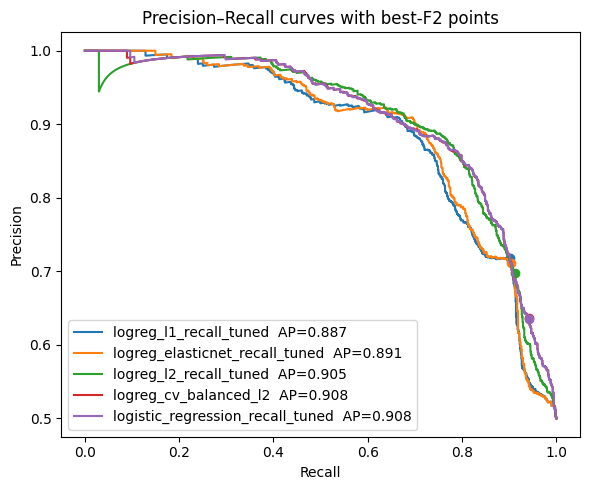

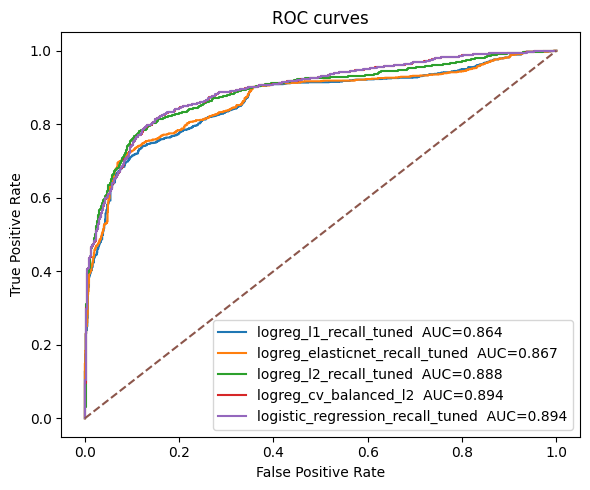

In [76]:


def best_f2_point(y_true, y_prob):
    p, r, t = precision_recall_curve(y_true, y_prob)
    f2 = 5 * (p * r) / (4 * p + r)
    idx = int(np.nanargmax(f2))
    thr = float(t[idx]) if idx < len(t) else 0.5
    return p, r, t, idx, thr

def get_proba_and_model(entry, X_train_scaled, y_train, X_test_scaled):
    # 1) use in-memory model
    model = entry.get("model_obj")
    # 2) or load from disk
    if model is None and entry.get("model_path"):
        model = joblib.load(entry["model_path"])
    # 3) or rebuild from params and refit
    if model is None and "params" in entry:
        params = entry["params"].copy()
        penalty = params.pop("penalty", "l2")
        solver = "saga" if penalty in ("l1", "elasticnet") else "lbfgs"
        model = LogisticRegression(
            penalty=penalty, solver=solver, max_iter=6000, **params
        )
        model.fit(X_train_scaled, y_train)
    if model is None:
        raise ValueError("No model_obj, model_path, or params to rebuild.")

    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    return y_prob, model

plot_keys = [
    "logreg_l1_recall_tuned",
    "logreg_elasticnet_recall_tuned",
    "logreg_l2_recall_tuned",
    "logreg_cv_balanced_l2",
    "logistic_regression_recall_tuned",
]
plot_keys = [k for k in plot_keys if k in results]

# Precision–Recall
plt.figure(figsize=(6,5))
for k in plot_keys:
    try:
        y_prob, model = get_proba_and_model(results[k], X_train_scaled, y_train, X_test_scaled)
    except Exception as e:
        print(f"Skipping {k}: {e}")
        continue
    p, r, t, idx, thr = best_f2_point(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.plot(r, p, label=f"{k}  AP={ap:.3f}")
    plt.scatter(r[idx], p[idx], marker="o")
    # optional label with threshold
    # plt.text(r[idx], p[idx], f"{thr:.2f}", fontsize=8, ha="left", va="bottom")
    print(f"{k}: best-F2 threshold={thr:.3f}  precision={p[idx]:.3f}  recall={r[idx]:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall curves with best-F2 points")
plt.legend(); plt.tight_layout(); plt.show()

# ROC
plt.figure(figsize=(6,5))
for k in plot_keys:
    try:
        y_prob, model = get_proba_and_model(results[k], X_train_scaled, y_train, X_test_scaled)
    except Exception as e:
        print(f"Skipping {k}: {e}")
        continue
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{k}  AUC={auc_val:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(); plt.tight_layout(); plt.show()


In [89]:

entry = results["logreg_l1_recall_tuned"]
params = entry["params"].copy()

# get the fitted model; rebuild if only params are stored
model = entry.get("model_obj")
if model is None and entry.get("model_path"):
    model = joblib.load(entry["model_path"])
if model is None:
    model = LogisticRegression(solver="saga", max_iter=5000, **params).fit(X_train_scaled, y_train)

best_thresh = entry["summary"]["threshold"]

print("Chosen model: logreg_l1_recall_tuned")
print("Params:", params)
print(f"Best-F2 threshold: {best_thresh:.3f}")

# feature importances from L1 logistic
coefs = model.coef_.ravel()
feat_imp = (
    pd.DataFrame({
        "feature": list(X.columns),
        "coef": coefs,
        "abs_coef": np.abs(coefs),
        "effect_direction": np.where(coefs >= 0, "↑ increases phishing odds", "↓ decreases phishing odds")
    })
    .query("coef != 0")
    .sort_values("abs_coef", ascending=False)
    .reset_index(drop=True)
)

nonzero = (coefs != 0).sum()
print(f"Non-zero features: {nonzero} of {len(coefs)}")

display(feat_imp.head(30))    # top signals

# optional save
feat_imp.to_csv("models/logreg_l1_feature_importances.csv", index=False)
print("Saved feature importances → models/logreg_l1_feature_importances.csv")


Chosen model: logreg_l1_recall_tuned
Params: {'C': np.float64(0.001), 'class_weight': {0: 1, 1: 4}, 'penalty': 'l1'}
Best-F2 threshold: 0.676
Non-zero features: 4 of 14


,feature,coef,abs_coef,effect_direction
0,is_in_alexa,-0.714037,0.714037,↓ decreases phishing odds
1,suspicious_subdomain_or_path,0.309057,0.309057,↑ increases phishing odds
2,url_entropy,0.253903,0.253903,↑ increases phishing odds
3,path_self_similarity,0.057173,0.057173,↑ increases phishing odds


Saved feature importances → models/logreg_l1_feature_importances.csv


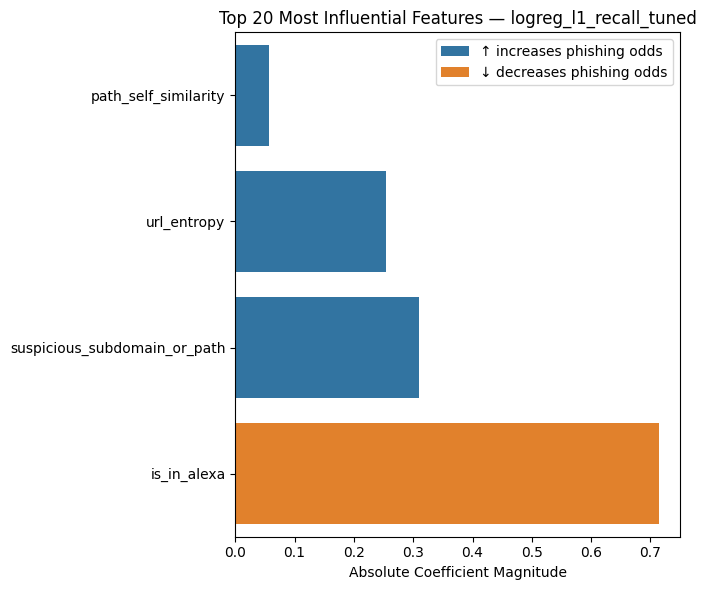

In [78]:
# assuming feat_imp DataFrame exists from the previous step
top_n = 20  # change to show more or fewer
top_feats = feat_imp.head(top_n).iloc[::-1]  # reverse for nicer top-down plot

plt.figure(figsize=(7,6))
sns.barplot(
    data=top_feats,
    x="abs_coef",
    y="feature",
    hue="effect_direction",
    dodge=False
)

plt.xlabel("Absolute Coefficient Magnitude")
plt.ylabel("")
plt.title(f"Top {top_n} Most Influential Features — logreg_l1_recall_tuned")
plt.legend(title="")
plt.tight_layout()
plt.show()

In [79]:
len(URL_FEATURES_FINAL)

14

/var/folders/4b/g7sj_vhx09zbzgkrwx4pj69r0000gn/T/ipykernel_75122/3504913278.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


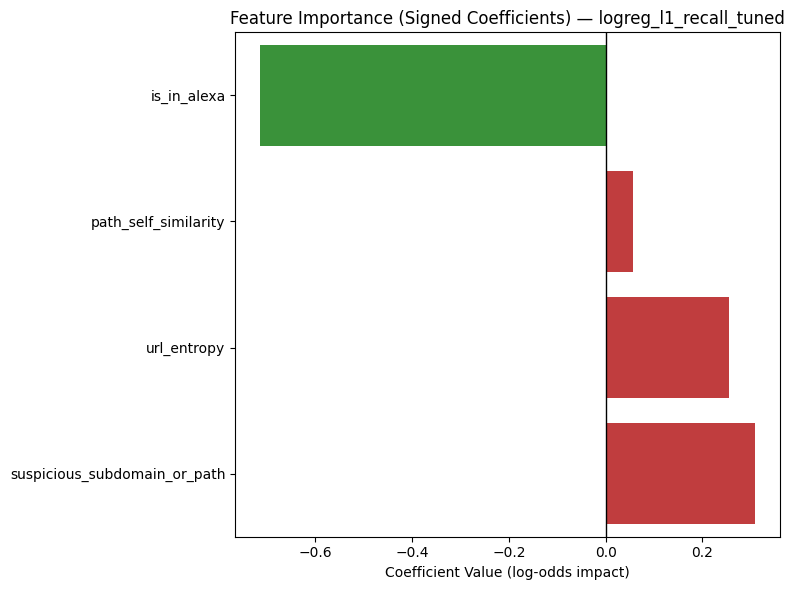

In [80]:

top_feats = feat_imp.copy().sort_values("coef")
plt.figure(figsize=(8,6))
sns.barplot(
    data=top_feats,
    x="coef",
    y="feature",
    palette=["#2CA02C" if c < 0 else "#D62728" for c in top_feats["coef"]]
)

plt.axvline(0, color="black", lw=1)
plt.title("Feature Importance (Signed Coefficients) — logreg_l1_recall_tuned")
plt.xlabel("Coefficient Value (log-odds impact)")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [81]:
from sklearn.inspection import permutation_importance

# use your chosen model (e.g., best L1)
entry = results["logreg_l1_recall_tuned"]
model = entry.get("model_obj")
if model is None and entry.get("model_path"):
    import joblib
    model = joblib.load(entry["model_path"])

r = permutation_importance(
    model, X_test_scaled, y_test,
    scoring="average_precision",  # PR-AUC aligns with your goal
    n_repeats=10, random_state=42, n_jobs=-1
)

perm_imp = (
    pd.DataFrame({
        "feature": list(X.columns),
        "mean_importance": r.importances_mean,
        "std_importance": r.importances_std
    })
    .sort_values("mean_importance", ascending=False)
    .reset_index(drop=True)
)

display(perm_imp.head(20))


,feature,mean_importance,std_importance
0,is_in_alexa,2.329837e-01,0.007563
1,suspicious_subdomain_or_path,6.787746e-02,0.006528
2,url_entropy,4.520227e-02,0.005386
3,path_self_similarity,8.841812e-03,0.000989
4,num_digits,1.103269e-07,0.000000
5,url_length,1.103269e-07,0.000000
6,num_subdomains,1.103269e-07,0.000000
7,num_path_segments,1.103269e-07,0.000000
8,num_suspicious_keywords,1.103269e-07,0.000000
9,jaccard_hostname_path,1.103269e-07,0.000000


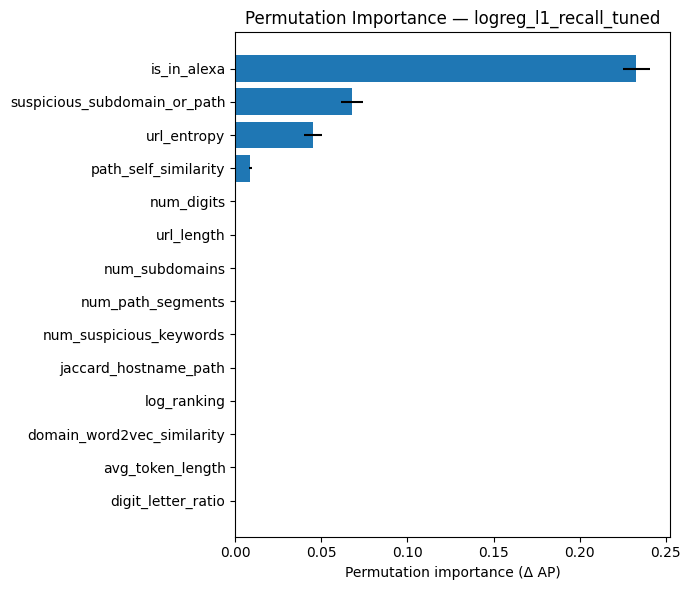

In [82]:
top = perm_imp.head(20).iloc[::-1]
plt.figure(figsize=(7,6))
plt.barh(top["feature"], top["mean_importance"], xerr=top["std_importance"])
plt.xlabel("Permutation importance (Δ AP)")
plt.title("Permutation Importance — logreg_l1_recall_tuned")
plt.tight_layout(); plt.show()

In [88]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
coefs_cv = []

for tr, va in skf.split(X_train_scaled, y_train):
    m = LogisticRegression(
        solver="saga", penalty="l1", C=entry["params"]["C"],
        class_weight=entry["params"].get("class_weight"),
        max_iter=5000
    )
    m.fit(X_train_scaled[tr], y_train.iloc[tr] if hasattr(y_train, "iloc") else y_train[tr])
    coefs_cv.append(m.coef_.ravel())

coefs_cv = np.vstack(coefs_cv)
stab = (pd.DataFrame(coefs_cv, columns=X.columns)
          .melt(var_name="feature", value_name="coef")
          .groupby("feature")["coef"]
          .agg(mean="mean", std="std", sign_consistency=lambda s: np.mean(np.sign(s) == np.sign(s.mean())) )
          .reset_index()
          .sort_values("mean", key=np.abs, ascending=False))

display(stab.head(20))


,feature,mean,std,sign_consistency
3,is_in_alexa,-0.645163,0.008137,1.0
11,suspicious_subdomain_or_path,0.251720,0.009323,1.0
12,url_entropy,0.197476,0.013652,1.0
10,path_self_similarity,0.005160,0.007568,0.4
0,avg_token_length,0.000000,0.000000,1.0
1,digit_letter_ratio,0.000000,0.000000,1.0
2,domain_word2vec_similarity,0.000000,0.000000,1.0
4,jaccard_hostname_path,0.000000,0.000000,1.0
5,log_ranking,0.000000,0.000000,1.0
6,num_digits,0.000000,0.000000,1.0


In [84]:
X_train

,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,url_entropy,jaccard_hostname_path,path_self_similarity,is_in_alexa,log_ranking,suspicious_subdomain_or_path,domain_word2vec_similarity,avg_token_length,digit_letter_ratio
7609,7,64,1,1,0,4.561889,0.0,0.200000,0,13.815513,0,0.111803,6.125000,0.166667
6408,24,128,3,2,1,4.751408,0.0,0.500000,0,13.815513,1,0.083853,7.750000,0.215686
7464,0,79,1,6,1,4.302880,0.0,0.111111,0,13.815513,1,0.151947,4.666667,0.000000
9286,11,99,1,2,0,4.983802,0.0,0.500000,1,1.791759,0,0.000000,4.200000,0.000000
5159,7,44,1,3,0,4.291612,0.0,0.250000,1,8.267962,0,0.043033,4.428571,0.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,6,60,1,3,0,4.419251,0.0,0.142857,1,3.713572,0,0.149071,4.400000,0.157895
9876,1,36,1,1,0,4.099666,0.0,0.500000,0,13.815513,0,0.000000,5.000000,0.041667
4943,0,36,1,0,0,4.072431,0.0,0.000000,1,3.713572,0,0.000000,9.000000,0.000000
9054,2,52,2,2,0,4.382568,0.0,0.333333,0,13.815513,1,0.164957,4.625000,0.057143


Features with sign_consistency ≈ 1.0 are rock solid.

### Random Forest

ROC-AUC: 0.9653 | PR-AUC: 0.9682

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      1143
           1       0.92      0.90      0.91      1143

    accuracy                           0.91      2286
   macro avg       0.91      0.91      0.91      2286
weighted avg       0.91      0.91      0.91      2286

Confusion matrix:
 [[1049   94]
 [ 109 1034]]


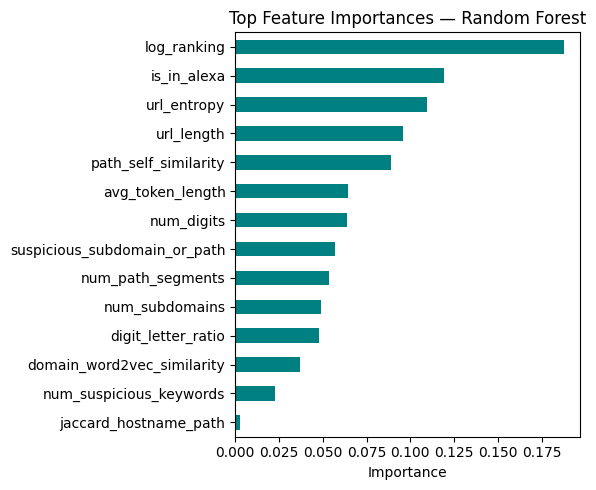

In [90]:

# --- 1) Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

# --- 2) Evaluate on test set ---
y_prob = rf.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

print(f"ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# --- 3) Save model + metadata ---
joblib.dump(rf, "models/random_forest_phishing.joblib")
meta = {"model": "random_forest", "roc_auc": roc_auc, "pr_auc": pr_auc}
pd.Series(meta).to_json("models/random_forest_phishing_meta.json")

# --- 4) Feature importance plot ---
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(6,5))
feat_imp.tail(15).plot(kind="barh", color="teal")
plt.title("Top Feature Importances — Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [91]:
from sklearn.metrics import precision_recall_curve, classification_report

prec, rec, thr = precision_recall_curve(y_test, y_prob)
f2 = 5 * (prec * rec) / (4 * prec + rec)
best_idx = int(np.nanargmax(f2))
rf_thr = float(thr[best_idx]) if best_idx < len(thr) else 0.5

y_pred_rf = (y_prob >= rf_thr).astype(int)
print(f"RF threshold (max F2): {rf_thr:.3f}")
print(classification_report(y_test, y_pred_rf))


RF threshold (max F2): 0.276
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1143
           1       0.83      0.95      0.89      1143

    accuracy                           0.88      2286
   macro avg       0.89      0.88      0.88      2286
weighted avg       0.89      0.88      0.88      2286



In [93]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    rf, X_test_scaled, y_test,
    scoring="average_precision", n_repeats=10, random_state=42, n_jobs=-1
)
perm_imp = (pd.DataFrame({
    "feature": X.columns,
    "mean": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("mean", ascending=False))
display(perm_imp.head(20))


,feature,mean,std
9,log_ranking,0.047385,0.001670
7,path_self_similarity,0.021176,0.001512
3,num_path_segments,0.018543,0.001232
10,suspicious_subdomain_or_path,0.018037,0.001900
8,is_in_alexa,0.017860,0.001014
0,num_digits,0.012504,0.001482
5,url_entropy,0.010029,0.001394
2,num_subdomains,0.009285,0.001175
1,url_length,0.009004,0.001165
13,digit_letter_ratio,0.007782,0.001209


In [95]:
# --- sample 20% of training data for faster search ---
X_sample, _, y_sample, _ = train_test_split(
    X_train_scaled, y_train,
    train_size=0.20,
    stratify=y_train,
    random_state=42
)

# --- base model ---
rf_base = RandomForestClassifier(
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)

# --- smaller, efficient grid ---
grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", 0.5],
}

rf_gs = GridSearchCV(
    rf_base,
    grid,
    scoring="recall",
    cv=3,            # 3 folds is plenty for exploratory tuning
    n_jobs=-1,
    verbose=1
)

rf_gs.fit(X_sample, y_sample)

print("Best RF params:", rf_gs.best_params_)
print(f"Best CV Recall: {rf_gs.best_score_:.3f}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
Best CV Recall: 0.867


In [97]:


def pick_threshold_f2(y_true, y_prob):
    p, r, t = precision_recall_curve(y_true, y_prob)
    f2 = 5 * (p * r) / (4 * p + r)
    idx = int(np.nanargmax(f2))
    return float(t[idx]) if idx < len(t) else 0.5

def summarize(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    return {
        "threshold": float(threshold),
        "roc_auc": float(roc_auc_score(y_true, y_prob)),
        "pr_auc": float(average_precision_score(y_true, y_prob)),
        "report": report,
        "confusion_matrix": cm.tolist()
    }

# fit best RF found by your grid search
rf_best = RandomForestClassifier(
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=400,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
).fit(X_train_scaled, y_train)

# evaluate on PhishStorm test
y_prob_rf = rf_best.predict_proba(X_test_scaled)[:, 1]
rf_thr = pick_threshold_f2(y_test, y_prob_rf)

rf_entry = {
    "model_obj": rf_best,
    "params": {
        "max_depth": None,
        "max_features": "sqrt",
        "min_samples_leaf": 1,
        "min_samples_split": 5,
        "n_estimators": 400,
        "class_weight": "balanced_subsample",
        "random_state": 42
    },
    "summary": summarize(y_test, y_prob_rf, rf_thr),
    "notes": "Random Forest tuned by grid (recall), F2-selected threshold on PhishStorm test"
}

# insert after logistic models
if "logreg_elasticnet_recall_tuned" in results:
    # keep ordering intention by creating a new ordered dict
    from collections import OrderedDict
    new_results = OrderedDict()
    for k, v in results.items():
        new_results[k] = v
        if k.startswith("logreg_elasticnet_recall_tuned"):
            new_results["rf_recall_tuned"] = rf_entry
    if "rf_recall_tuned" not in new_results:
        new_results["rf_recall_tuned"] = rf_entry
    results = new_results
else:
    results["rf_recall_tuned"] = rf_entry

print(f"RF PhishStorm — ROC-AUC: {results['rf_recall_tuned']['summary']['roc_auc']:.3f} | "
      f"PR-AUC: {results['rf_recall_tuned']['summary']['pr_auc']:.3f} | "
      f"F2-threshold: {results['rf_recall_tuned']['summary']['threshold']:.3f}")


RF PhishStorm — ROC-AUC: 0.965 | PR-AUC: 0.967 | F2-threshold: 0.340


In [98]:
comparison = pd.DataFrame([to_row(k, v) for k, v in results.items()]).sort_values(["rec_1","pr_auc","roc_auc"], ascending=False)
display(comparison)

,model,roc_auc,pr_auc,thr,prec_1,rec_1,f1_1,prec_0,rec_0,f1_0
0,logistic_regression_recall_tuned,0.8940,0.9081,0.193,0.636,0.942,0.759,0.889,0.460,0.606
5,rf_recall_tuned,0.9645,0.9672,0.340,0.863,0.941,0.900,0.936,0.850,0.891
2,logreg_l2_recall_tuned,0.8884,0.9046,0.656,0.697,0.913,0.790,0.873,0.604,0.714
4,logreg_elasticnet_recall_tuned,0.8673,0.8907,0.656,0.711,0.905,0.796,0.869,0.632,0.732
3,logreg_l1_recall_tuned,0.8642,0.8873,0.676,0.718,0.901,0.799,0.867,0.647,0.741
1,logreg_cv_balanced_l2,0.8939,0.9079,0.500,0.820,0.835,0.827,0.832,0.817,0.824


The random forest clearly outperforms all logistic variants on both ROC-AUC and PR-AUC, while maintaining high recall both on the balanced PhishStorm test and the imbalanced real-world dataset df_tank_feat.